Dataset From https://www.kaggle.com/oddrationale/mnist-in-csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_data = pd.read_csv('./data/train.csv')
to_pred = pd.read_csv('./data/test.csv')

由于数据集特征过多,且在数据集背景介绍中已经介绍数据没有空值, 均为28 * 28的灰度图(像素值为0-255),所以只略微预览一下head, 不预览describe和info(预览了也看不过来)

In [3]:
base_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
to_pred.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
base_data_y = base_data['label']
base_data_x = base_data.drop(labels = ["label"], axis = 1) 

In [6]:
base_data_y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [7]:
# 直接标准化至0-1区间方便后面进行建模
base_data_x = base_data_x/255.0
to_pred = to_pred/255.0
base_data_x = base_data_x.values.reshape(-1,28,28,1) # 在numpy中,-1的意思是根据其余维度的值计算出填写了-1的位置. 原来的x总维度是n*784,我们将其变为n * 28 * 28 * 1(最后那个1代表一个图像)的多维项链
to_pred = to_pred.values.reshape(-1,28,28,1)

分割测试集与训练集,这里random_state是让每一次运行结果固定(否则会不一样), 并把y转换成tensorflow可以正确计算的离散十分类

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

base_data_y = to_categorical(base_data_y, num_classes = 10)
print("y现在长这样:")
print(base_data_y[0])
x_train, x_val, y_train, y_val = train_test_split(base_data_x, base_data_y, test_size = 0.2, random_state=2)

y现在长这样:
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


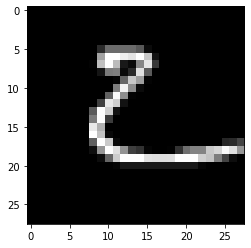

In [9]:
plt.imshow(x_train[0], cmap = 'gray')

In [10]:
# 需要用到的tensorflow模块
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

把y转成tensorflow可以计算的十分类

In [11]:
model = Sequential()
# filters: 卷积核个数.随着卷积核个数增加,能够提取的特征数量也越多.比如四个卷积核可能只能提取狗头,狗尾巴.而128个卷积核可以提取狗鼻子,狗耳朵等细节部位
# kernel_size: 卷积核大小
# 卷积核大小御卷积核个数的解释详见: https://blog.csdn.net/xys430381_1/article/details/82529397 中卷积核的运算过程
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# 池化层
model.add(MaxPool2D(pool_size=(2,2)))
# 随即丢弃,避免过拟合
model.add(Dropout(0.2))

# 增加filters,减小kernel_size,使得提取精细化
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
# 分为10类
model.add(Dense(10, activation = "softmax"))

In [12]:
reduce_lr = ReduceLROnPlateau(monitor= "loss", factor = 0.5, patience = 3,
                                                 min_lr = 0.000001, verbose = 1)
#简单图像分类的CNN代数一般比LSTM等少很多,其实一般不需要early stopping
monitor_es = EarlyStopping(monitor= "loss", patience = 8, restore_best_weights= False, verbose = True)

In [13]:
model.compile(Adam(lr = 0.001), loss = ["mean_squared_error"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [15]:
train_history = model.fit(x_train, y_train, epochs = 30, batch_size = 32, callbacks = [reduce_lr, monitor_es], validation_data=(x_val, y_val))

Epoch 1/30
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0091 - val_loss: 0.0036
Epoch 2/30
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/30
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 4/30
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 5/30
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/30
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 7/30
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/30
1044/1050 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 9/30
1050/1050 [==============

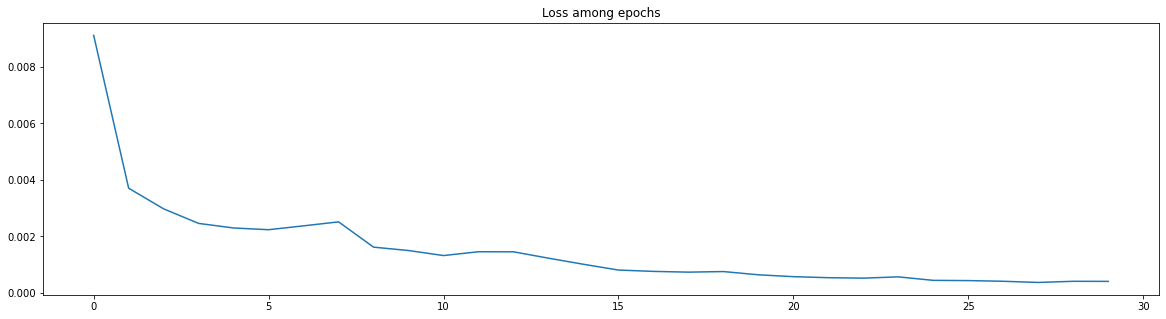

In [16]:
plt.figure(figsize = (20, 5))
plt.plot(train_history.history["loss"])
plt.title("Loss among epochs")
plt.show()

In [19]:
results = model.predict(to_pred)
results = np.argmax(results,axis = 1)
# 转成Pandas Series方便提交
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1, len(to_pred) + 1),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn.csv",index=False)